In [76]:
import requests
import pandas as pd
from datetime import datetime, timedelta
from pprint import pprint
import time
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

Пожары в России за 2012-2021 гг. https://data.rcsi.science/data-catalog/datasets/202/#dataset-overview

In [3]:
forrest_fire = pd.read_csv('thermopoints.csv', sep=';')
forrest_fire

,dt,type_name,type_id,lon,lat
0,2012-03-13,Природный пожар,4,131.5866,47.8662
1,2012-03-13,Природный пожар,4,131.5885,47.8809
2,2012-03-13,Лесной пожар,3,131.9871,48.4973
3,2012-03-13,Природный пожар,4,131.9031,43.6277
4,2012-03-13,Природный пожар,4,131.5706,47.8581
...,...,...,...,...,...
660249,2021-09-10,Лесной пожар,3,118.5451,64.7475
660250,2021-09-10,Лесной пожар,3,118.3046,64.7629
660251,2021-09-10,Лесной пожар,3,117.9681,65.7394
660252,2021-09-10,Лесной пожар,3,119.0462,64.7541


Будем рассматривать лесные пожары летом и в сентябре.

In [4]:
forrest_fire = forrest_fire[forrest_fire['type_name'] == 'Лесной пожар' ]
forrest_fire = forrest_fire.drop_duplicates(subset=['dt'])
forrest_fire = forrest_fire[['dt', 'lon', 'lat']]
forrest_fire['dt'] = pd.to_datetime(forrest_fire['dt'])
forrest_fire['month'] = forrest_fire['dt'].dt.month
forrest_fire = forrest_fire[(forrest_fire['month'] < 10) & (forrest_fire['month'] > 5)]
forrest_fire

,dt,lon,lat,month
1897,2012-06-01,66.3320,63.7988,6
1972,2012-06-02,136.7256,60.7618,6
2248,2012-06-03,124.1010,53.6320,6
2362,2012-06-04,140.1607,60.6553,6
2727,2012-06-05,140.2069,58.9203,6
...,...,...,...,...
658692,2021-09-06,121.0165,66.7575,9
659052,2021-09-07,118.8730,64.7312,9
659334,2021-09-08,141.4489,62.9088,9
659674,2021-09-09,122.8659,66.6548,9


Получение погодных данных с помощью api запросов в день пожаров и за 2 дня до него. https://www.visualcrossing.com/

In [17]:
API_KEY = 'JGB3E6K8CNPVWWLSFBF5XKFNL'
#API_KEY = '7TM5XPHE3AMUHWQ3XPVHXL4EL'
#API_KEY = 'VQ959KJETGEP22HECX5R3CPQQ' 
#API_KEY = 'MS77XFUHC76YM9C9UUG5KF72W'
def fetch_weather(row):
    dt, lon, lat = row['dt'], row['lon'], row['lat']
    
    dates = [(dt - timedelta(days=i)).strftime("%Y-%m-%d") for i in range(2, -1, -1)]
    
    url = f"https://weather.visualcrossing.com/VisualCrossingWebServices/rest/services/timeline/{lat},{lon}/{dates[0]}/{dates[-1]}"
    params = {
        "key": API_KEY,
        "include": "days",
        "elements": "datetime,tempmax,humidity,windspeed,precip"
    }

    response = requests.get(url, params=params)
    if response.status_code == 200:
        days_data = response.json().get("days", [])

        rows = []
        for day in days_data:
            rows.append({
                "dt": day["datetime"],  
                "lat": lat,
                "lon": lon,
                "temp": round((day["tempmax"] - 32) * 5 / 9, 1),  
                "humidity": day["humidity"],
                "windspeed": round(day["windspeed"] * 1.6, 1),  
                "precip": round(day["precip"] * 25.4, 1)
            })
        
        return pd.DataFrame(rows)
    else:
        print(f"⚠️ Ошибка запроса для dt {dt}: статус {response.status_code}")
        return pd.DataFrame()  

locations_df = forrest_fire.iloc[998:1054]

result_list = []
for index, row in locations_df.iterrows():
    df_weather = fetch_weather(row)
    result_list.append(df_weather)

firecast_df = pd.concat(result_list, ignore_index=True)

Создание признака пожара (fire) 1 - был пожар, 0 - не было.

In [33]:
firecast_df['fire'] = (firecast_df.index % 3 == 2).astype(int)
firecast_df.head(12)

,dt,lat,lon,temp,humidity,windspeed,precip,fire,year,month,day
0,2021-07-14,60.9660,28.7680,31.4,60.0,13.6,0.0,0,2021,7,14
1,2021-07-15,60.9660,28.7680,31.9,64.5,15.5,0.0,0,2021,7,15
2,2021-07-16,60.9660,28.7680,26.8,65.0,22.2,0.0,1,2021,7,16
3,2021-07-15,60.9917,30.0575,31.6,65.7,19.8,0.0,0,2021,7,15
4,2021-07-16,60.9917,30.0575,28.2,64.3,21.4,0.0,0,2021,7,16
5,2021-07-17,60.9917,30.0575,26.1,60.2,14.2,0.0,1,2021,7,17
6,2021-07-16,62.0579,33.0667,31.0,61.9,21.4,1.0,0,2021,7,16
7,2021-07-17,62.0579,33.0667,25.3,54.4,14.2,0.0,0,2021,7,17
8,2021-07-18,62.0579,33.0667,29.0,57.4,28.6,0.0,1,2021,7,18
9,2021-07-17,62.0145,33.2355,25.3,54.4,14.2,0.0,0,2021,7,17


Преобразование столбца dt в тип datetime и добавляем три столбца year, month, day.

In [34]:
firecast_df['dt'] = pd.to_datetime(firecast_df['dt'])
firecast_df['year'] = firecast_df['dt'].dt.year
firecast_df['month'] = firecast_df['dt'].dt.month
firecast_df['day'] = firecast_df['dt'].dt.day
firecast_df.head()

,dt,lat,lon,temp,humidity,windspeed,precip,fire,year,month,day
0,2021-07-14,60.9660,28.7680,31.4,60.0,13.6,0.0,0,2021,7,14
1,2021-07-15,60.9660,28.7680,31.9,64.5,15.5,0.0,0,2021,7,15
2,2021-07-16,60.9660,28.7680,26.8,65.0,22.2,0.0,1,2021,7,16
3,2021-07-15,60.9917,30.0575,31.6,65.7,19.8,0.0,0,2021,7,15
4,2021-07-16,60.9917,30.0575,28.2,64.3,21.4,0.0,0,2021,7,16


Построим гистрограмму и коробчатую диаграмму для признака temp - температура (C).

Text(0.5, 1.0, 'Temp Boxplot')

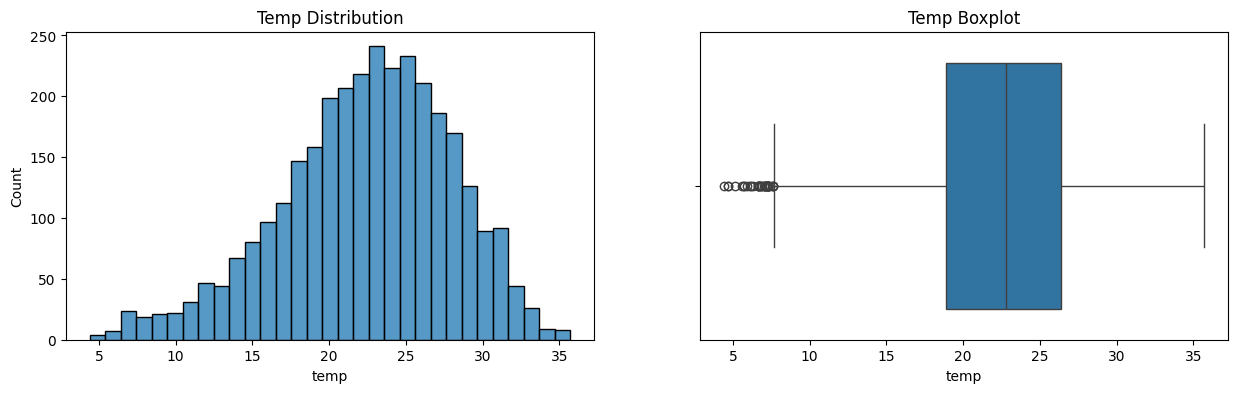

In [35]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=firecast_df, x='temp', ax=axes[0])
histplot.set_title('Temp Distribution')
boxplot = sns.boxplot(data=firecast_df, x='temp', ax=axes[1])
boxplot.set_title('Temp Boxplot')

Метод межквартильного размаха.

In [36]:
def outliers_iqr(data, feature):
    x = data[feature]
    quartile_1, quartile_3 = x.quantile(0.25), x.quantile(0.75),
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_1 - (iqr * 1.5)
    upper_bound = quartile_3 + (iqr * 1.5)
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

In [ ]:
outliers, firecast_df = outliers_iqr(firecast_df, 'temp')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {firecast_df.shape[0]}')

Число выбросов по методу Тьюки: 38
Результирующее число записей: 3124


Графики после очистки методом межквартильного размаха.

Text(0.5, 1.0, 'Cleaned Temp Boxplot')

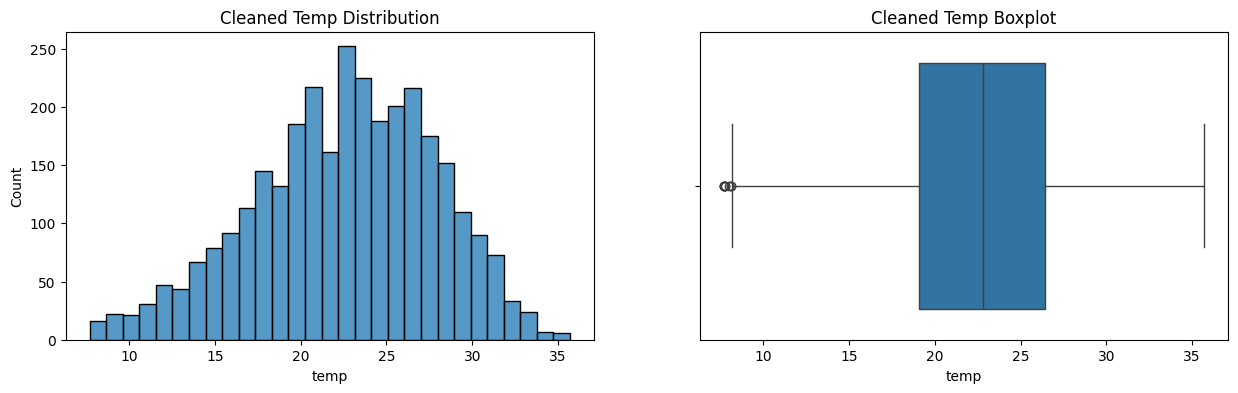

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=firecast_df, x='temp', ax=axes[0])
histplot.set_title('Cleaned Temp Distribution')
boxplot = sns.boxplot(data=firecast_df, x='temp', ax=axes[1])
boxplot.set_title('Cleaned Temp Boxplot')

Построим гистрограмму и коробчатую диаграмму для признака humidity - относительная влажность (%).

Text(0.5, 1.0, 'Humidity Boxplot')

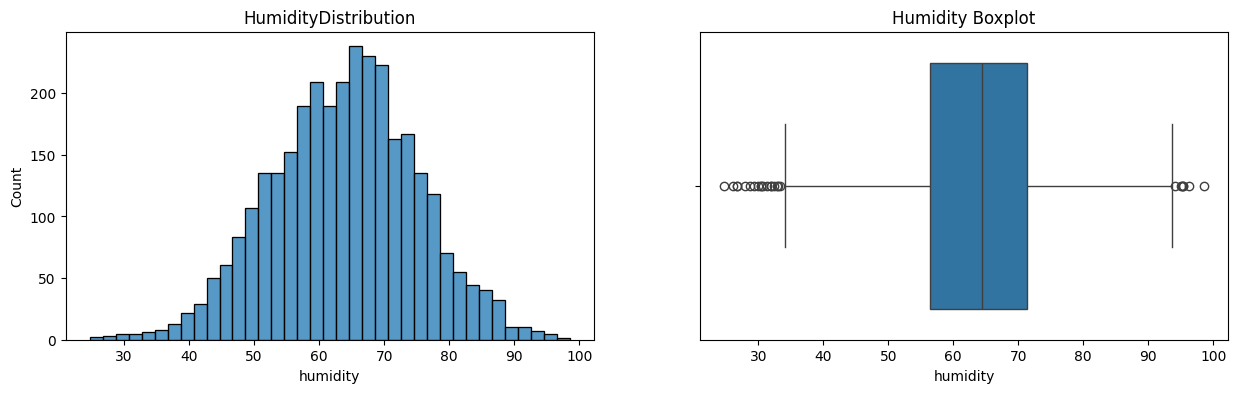

In [39]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=firecast_df, x='humidity', ax=axes[0])
histplot.set_title('HumidityDistribution')
boxplot = sns.boxplot(data=firecast_df, x='humidity', ax=axes[1])
boxplot.set_title('Humidity Boxplot')

In [ ]:
outliers, firecast_df = outliers_iqr(firecast_df, 'humidity')
print(f'Число выбросов по методу Тьюки: {outliers.shape[0]}')
print(f'Результирующее число записей: {cleaned.shape[0]}')

Число выбросов по методу Тьюки: 25
Результирующее число записей: 3099


Графики после очистки методом межквартильного размаха.

Text(0.5, 1.0, 'Cleaned Humidity Boxplot')

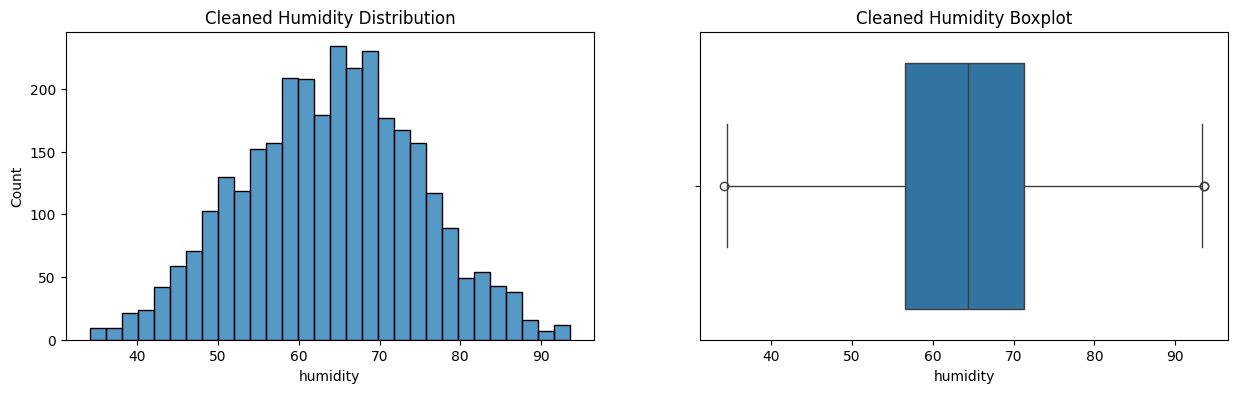

In [ ]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 4))
histplot = sns.histplot(data=firecast_df, x='humidity', ax=axes[0])
histplot.set_title('Cleaned Humidity Distribution')
boxplot = sns.boxplot(data=firecast_df, x='humidity', ax=axes[1])
boxplot.set_title('Cleaned Humidity Boxplot')

Построим две гистограммы для признака windspeed - скрость ветра (км/ч), первая — в обычном масштабе, а вторая — в логарифмическом.

Text(0.5, 1.0, 'Log Windspeed Distribution')

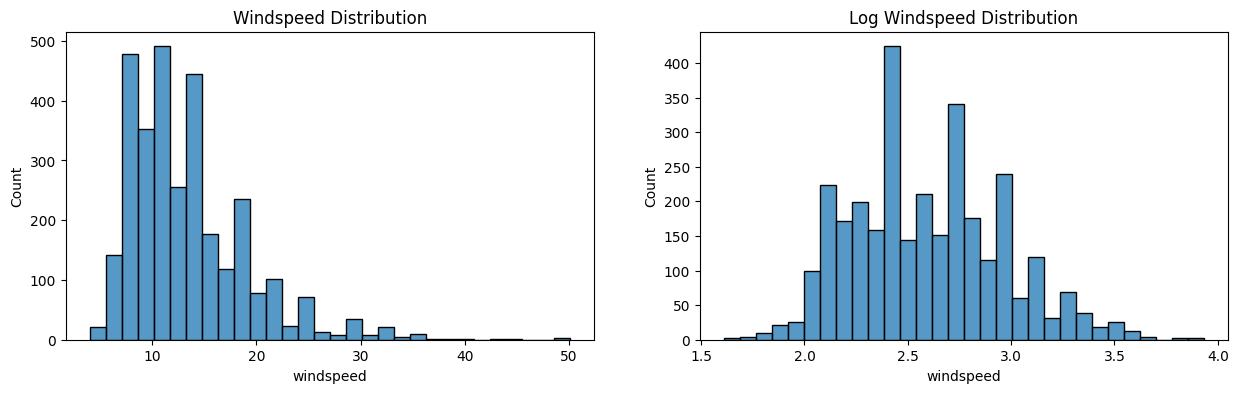

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
histplot = sns.histplot(firecast_df['windspeed'], bins=30, ax=axes[0])
histplot.set_title('Windspeed Distribution')

log_mkad_km= np.log(firecast_df['windspeed'] + 1)
histplot = sns.histplot(log_mkad_km , bins=30, ax=axes[1])
histplot.set_title('Log Windspeed Distribution')

Метод z-отклонений.

In [43]:
def outliers_z_score_mod(data, feature, log_scale=False, left= 3, right= 3):
    if log_scale:
        x = np.log(data[feature]+1)
    else:
        x = data[feature]
    mu = x.mean()
    sigma = x.std()
    lower_bound = mu - left * sigma
    upper_bound = mu + right * sigma
    outliers = data[(x < lower_bound) | (x > upper_bound)]
    cleaned = data[(x >= lower_bound) & (x <= upper_bound)]
    return outliers, cleaned

Text(0.5, 1.0, 'Log Windspeed Distribution')

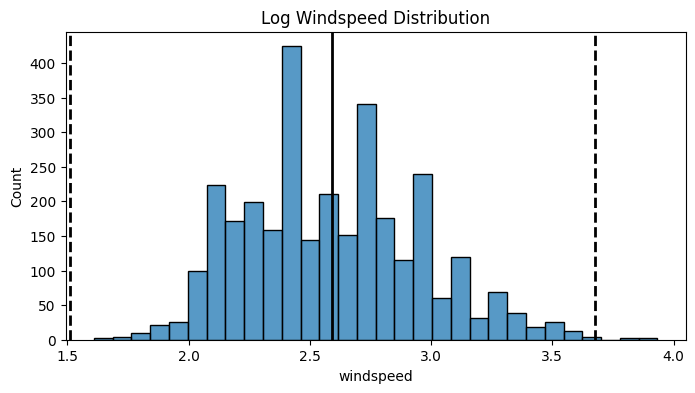

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4))
log_mkad_km = np.log(firecast_df['windspeed'] + 1)
histplot = sns.histplot(log_mkad_km, bins=30, ax=ax)
histplot.axvline(log_mkad_km.mean(), color='k', lw=2)
histplot.axvline(log_mkad_km.mean()+ 3 * log_mkad_km.std(), color='k', ls='--', lw=2)
histplot.axvline(log_mkad_km.mean()- 3 * log_mkad_km.std(), color='k', ls='--', lw=2)
histplot.set_title('Log Windspeed Distribution')

In [ ]:
outliers, firecast_df = outliers_z_score_mod(firecast_df, 'windspeed', log_scale=True)
print(f'Число выбросов по методу z-отклонения: {outliers.shape[0]}')
print(f'Результирующее число записей: {firecast_df.shape[0]}')

Число выбросов по методу z-отклонения: 7
Результирующее число записей: 3092


График после очистки методом межквартильного размаха.

Text(0.5, 1.0, 'Cleaned Windspeed Distribution')

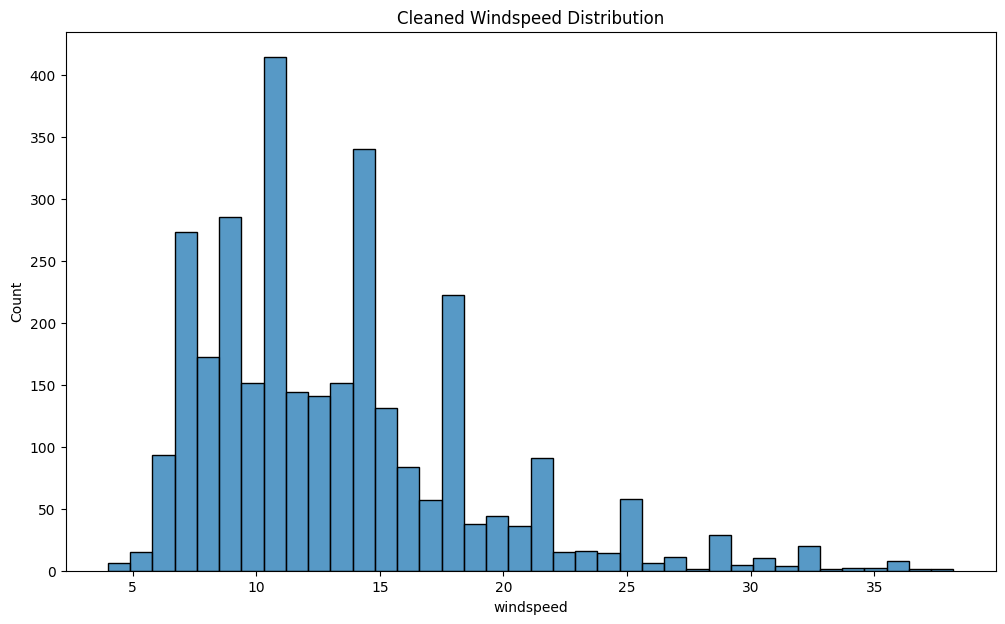

In [ ]:
fig = plt.subplots(figsize=(12, 7))
histplot = sns.histplot(data=firecast_df, x='windspeed')
histplot.set_title('Cleaned Windspeed Distribution')

Оставим только необходимые признаки, сбросим индексы и запишем df их в csv файл.

In [ ]:
firecast_df = firecast_df.drop(columns= ['dt', 'lon', 'year', 'day'])

In [ ]:
compression_opts = dict(method='zip', archive_name='dataset.csv') 
firecast_df.to_csv('dataset.zip', index=False, compression=compression_opts)

In [73]:
firecast_df.head(12)

,lat,temp,humidity,windspeed,precip,fire,month
0,60.9660,31.4,60.0,13.6,0.0,0,7
1,60.9660,31.9,64.5,15.5,0.0,0,7
2,60.9660,26.8,65.0,22.2,0.0,1,7
3,60.9917,31.6,65.7,19.8,0.0,0,7
4,60.9917,28.2,64.3,21.4,0.0,0,7
5,60.9917,26.1,60.2,14.2,0.0,1,7
6,62.0579,31.0,61.9,21.4,1.0,0,7
7,62.0579,25.3,54.4,14.2,0.0,0,7
8,62.0579,29.0,57.4,28.6,0.0,1,7
9,62.0145,25.3,54.4,14.2,0.0,0,7


Получение регионов с помощью api запросов. https://docs.locationiq.com/

In [ ]:
REGION_API_KEY = 'pk.75bd506ce93aed96139f28e16410fcb9'
#REGION_API_KEY = 'pk.b31768339c26465ba31eb25fcc8a1db9 '
def getRegion(row):

    lon, lat =  row['lon'], row['lat']

    url = f"https://us1.locationiq.com/v1/reverse?key={REGION_API_KEY}&lat={lat}&lon={lon}&format=json"

    response = requests.get(url)

    if response.status_code == 200:
        data = response.json()
        region = data['address'].get('region', None)
    else:
        print(f"Ошибка {response.status_code}: {response.text}")
        region = None

    time.sleep(1)

    return region

firecast_df['region'] = firecast_df.apply(getRegion, axis= 1)
firecast_df

In [ ]:
firecast_df['region'].value_counts()

In [ ]:
regions_code = {'Far Eastern Federal District': 1,
                'Siberian Federal District': 2,
                'Ural Federal District': 3,
                'Volga Federal District': 4,
                'Central Federal District': 5,
                'Northwestern Federal District': 6,}

def codingRegion(x):
    return regions_code[x]

firecast_df['region_code'] = firecast_df['region'].apply(codingRegion)
firecast_df.head(12)

# compression_opts = dict(method='zip', archive_name='out.csv') 
# cleaned.to_csv('data/out.zip', index=False, compression=compression_opts)